<a href="https://colab.research.google.com/github/charleynas/Effective-and-Ineffective-Hockey-Shots/blob/main/Actual_Data_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import everything that we need

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#read in the initial csv

df = pd.read_csv('nhl-shots-2021.csv')
df.head()

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,2021020001,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,1137,3537,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Steven.Stamkos,Shooter,Tristan.Jarry,Goalie,EV,61.0,-32.0,42.5,48.8
1,2021020001,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,1115,3515,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Zach.Bogosian,Shooter,Brock.McGinn,Blocker,EV,60.0,-17.0,NaN,NaN
2,2021020001,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,1096,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Brock.McGinn,Shooter,Andrei.Vasilevskiy,Goalie,EV,-65.0,19.0,30.6,38.4
3,2021020001,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,1079,3479,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Jan.Rutta,Shooter,Tristan.Jarry,Goalie,EV,-8.0,-27.0,100.7,15.6
4,2021020001,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,1033,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Danton.Heinen,Shooter,Andrei.Vasilevskiy,Goalie,EV,-60.0,-4.0,29.3,7.9


In [ ]:
#clean dataset of unneeded things

del df['game_id']
del df['period_seconds_remaining']
del df['away_name']
del df['event_goalie_name']
del df["event_player_1_name"]
del df["event_player_2_name"]
del df["event_player_1_type"]
del df["event_player_2_type"]
df.head()

,description,shot_outcome,period,game_seconds_remaining,home_score,away_score,home_name,event_team,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,3537,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,61.0,-32.0,42.5,48.8
1,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,3515,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,60.0,-17.0,NaN,NaN
2,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-65.0,19.0,30.6,38.4
3,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,3479,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,-8.0,-27.0,100.7,15.6
4,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-60.0,-4.0,29.3,7.9


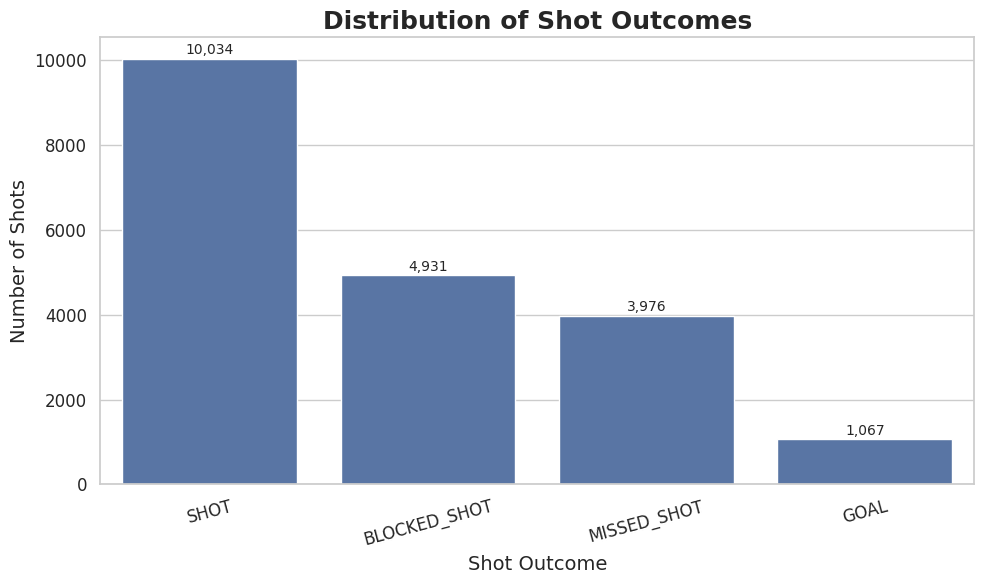

In [ ]:
#calculate types of shots and how much per each one

# Clean theme
sns.set_theme(style="whitegrid")

# Count outcomes
shot_outcome_counts = df['shot_outcome'].value_counts().reset_index()
shot_outcome_counts.columns = ['Shot Outcome', 'Count']

# Sort by count
shot_outcome_counts = shot_outcome_counts.sort_values('Count', ascending=False)

#plot
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x='Shot Outcome',
    y='Count',
    data=shot_outcome_counts
)

# Add value labels
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() + max(shot_outcome_counts['Count']) * 0.01,
        f"{int(p.get_height()):,}",
        ha='center', fontsize=10
    )

plt.title('Distribution of Shot Outcomes', fontsize=18, weight='bold')
plt.xlabel('Shot Outcome', fontsize=14)
plt.ylabel('Number of Shots', fontsize=14)

plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
#make new col for the type of shot based on the description

def classify_shot(desc):
    d = desc.lower()

    if "wrist" in d:
        return "wrist"
    if "slap" in d:
        return "slap"
    if "snap" in d:
        return "snap"
    if "tip" in d or "deflect" in d:
        return "tip-in"
    if "backhand" in d:
        return "backhand"
    if "wrap" in d:
        return "wrap_around"

    return "unknown"

df['shot_type'] = df['description'].apply(classify_shot)

# Drop rows where shot_type is "unknown"
df = df[df['shot_type'] != "unknown"]
df.head()

,description,shot_outcome,period,game_seconds_remaining,home_score,away_score,home_name,event_team,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type
0,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,3537,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,61.0,-32.0,42.5,48.8,wrist
2,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-65.0,19.0,30.6,38.4,wrist
3,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,3479,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,-8.0,-27.0,100.7,15.6,wrist
4,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,NaN,EV,-60.0,-4.0,29.3,7.9,wrist
5,Ondrej Palat Wrist Shot saved by Tristan Jarry,SHOT,1,3413,0,0,Tampa Bay Lightning,Tampa Bay Lightning,NaN,EV,63.0,4.0,26.3,8.7,wrist


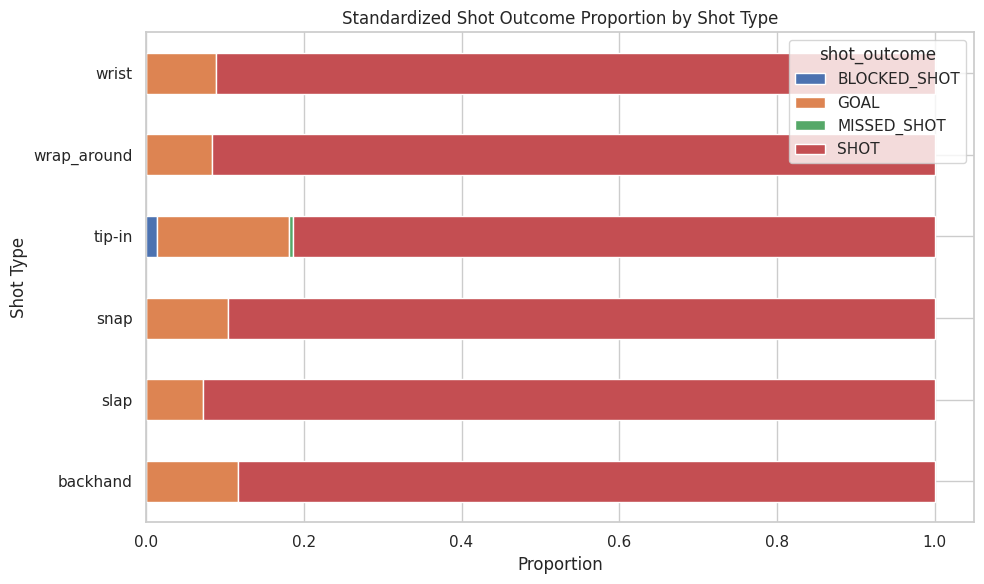

In [ ]:
#get the number of each shot outcome for each shot type by proportions so easier to compare

# Count combinations
counts = df.groupby(['shot_type', 'shot_outcome']).size().reset_index(name='count')


# Pivot to get counts
pivot = df.pivot_table(
    index='shot_type',
    columns='shot_outcome',
    aggfunc='size',
    fill_value=0
)

# Standardize rows to proportions
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0)

# Plot
pivot_norm.plot(kind='barh', stacked=True, figsize=(10, 6))

plt.xlabel("Proportion")
plt.ylabel("Shot Type")
plt.title("Standardized Shot Outcome Proportion by Shot Type")
plt.tight_layout()
plt.show()

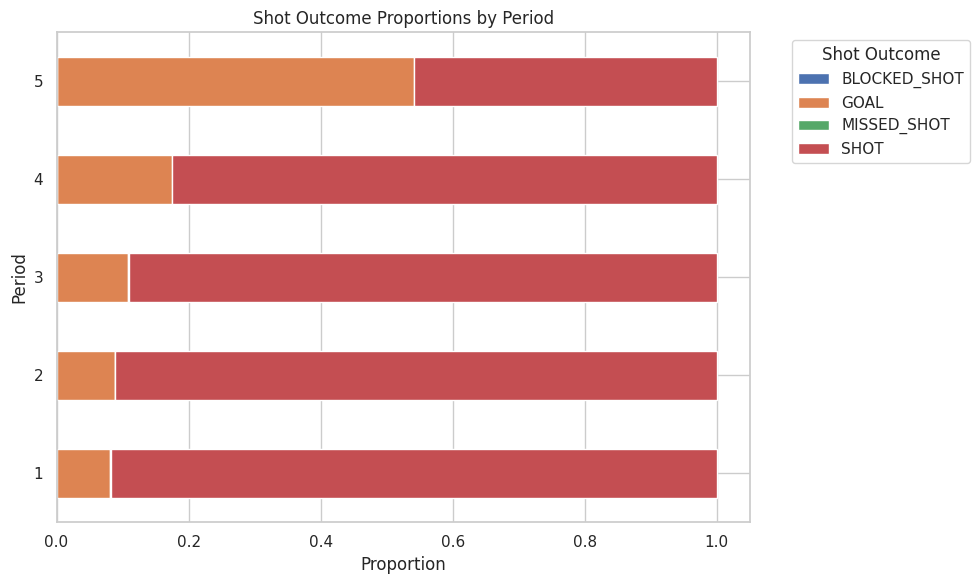

In [ ]:
#calculate the number of shot outcomes per period - proportions

# Count outcomes per period
counts = (
    df.groupby(["period", "shot_outcome"])
      .size()
      .reset_index(name="count")
)

#compute proportions
counts["proportion"] = (
    counts["count"] / counts.groupby("period")["count"].transform("sum")
)

# Pivot for stacked bar chart
pivot = counts.pivot(index="period", columns="shot_outcome", values="proportion")

# Plot
pivot.plot(kind="barh", stacked=True, figsize=(10, 6))

plt.title("Shot Outcome Proportions by Period")
plt.xlabel("Proportion")
plt.ylabel("Period")
plt.legend(title="Shot Outcome", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

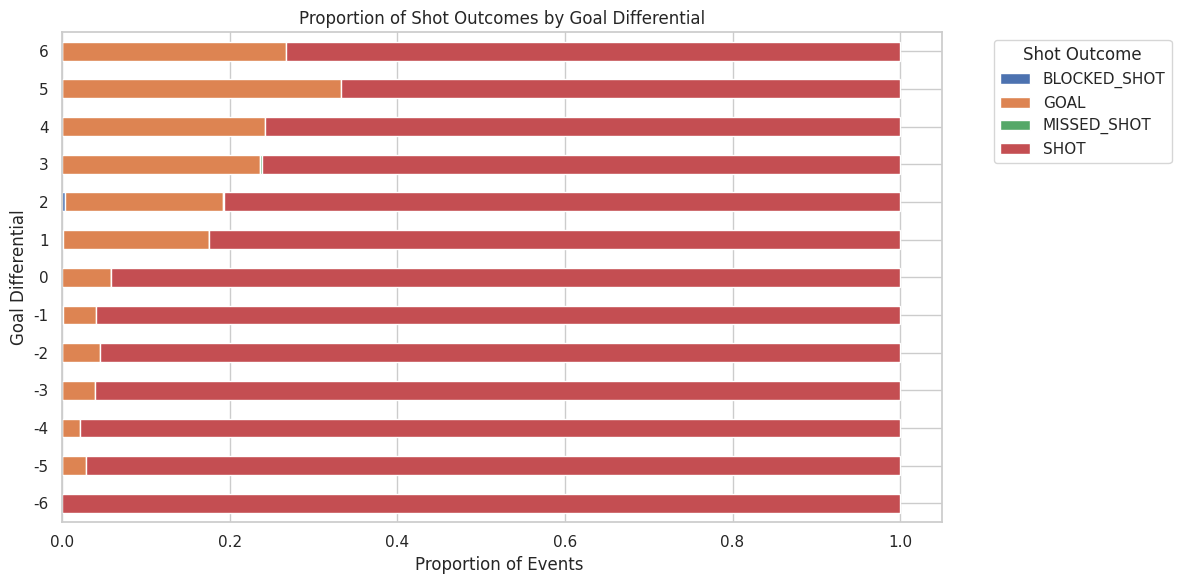

In [ ]:
#calculate the number of shot outcomes per goal differential - proportions

#calculate goal differential
df["goal_differential"] = np.where(
    df["event_team"] == df["home_name"],
    df["home_score"] - df["away_score"],
    df["away_score"] - df["home_score"]
)


sns.set_theme(style="whitegrid")

# Count combinations
counts = (
    df.groupby(["goal_differential", "shot_outcome"])
      .size()
      .reset_index(name="count")
)

# compute proportions
counts["proportion"] = (
    counts["count"] / counts.groupby("goal_differential")["count"].transform("sum")
)

# Pivot for plotting
pivot = counts.pivot(
    index="goal_differential",
    columns="shot_outcome",
    values="proportion"
).fillna(0)

# Plot
pivot.plot(
    kind="barh",
    stacked=True,
    figsize=(12, 6)
)

plt.title("Proportion of Shot Outcomes by Goal Differential")
plt.xlabel("Proportion of Events ")
plt.ylabel("Goal Differential")
plt.legend(title="Shot Outcome", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

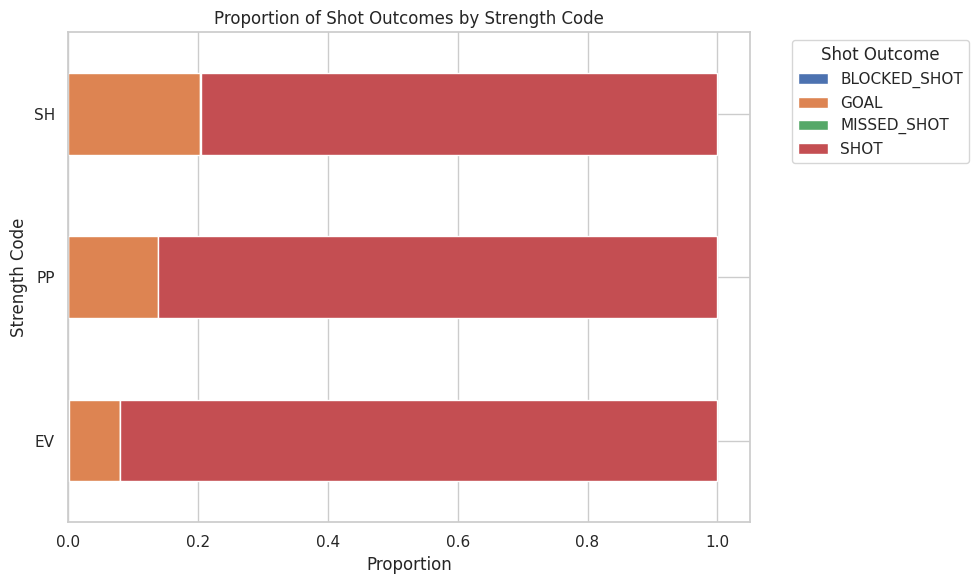

In [ ]:
#calculate the number of shot outcomes per strength code - proportions

# Count combinations
counts = (
    df.groupby(["strength_code", "shot_outcome"])
      .size()
      .reset_index(name="count")
)

#proportions
counts["proportion"] = (
    counts["count"] / counts.groupby("strength_code")["count"].transform("sum")
)

# Pivot
pivot = counts.pivot(
    index="strength_code",
    columns="shot_outcome",
    values="proportion"
)

# Plot
pivot.plot(
    kind="barh",
    stacked=True,
    figsize=(10,6)
)

plt.title("Proportion of Shot Outcomes by Strength Code")
plt.xlabel("Proportion")
plt.ylabel("Strength Code")
plt.legend(title="Shot Outcome", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


/tmp/ipython-input-2887219327.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['shot_side', 'angle_bin'])['is_goal']


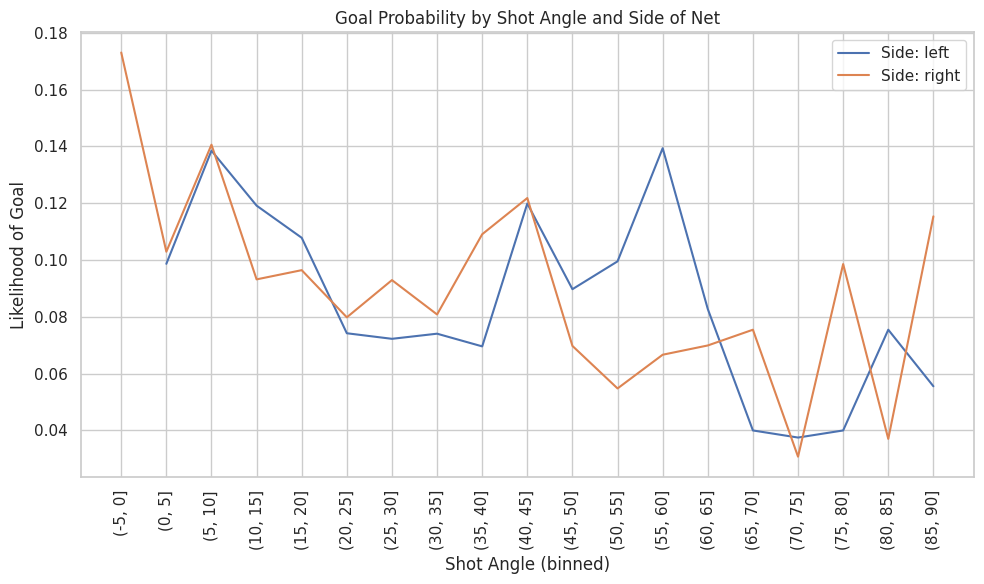

In [ ]:
#calculate the probability of goal based on the shot angle


df['is_goal'] = (df['shot_outcome'] == 'GOAL').astype(int)
#goal center y-coordinate is 0
y_center = 0

# Create a column for which side of net the shot comes from and make bins
df['shot_side'] = df['y_fixed'].apply(lambda y: 'left' if y < y_center else 'right')
df['angle_bin'] = pd.cut(df['shot_angle'], bins=range(-90, 95, 5))

#calculate probabilities
angle_side_goal_rates = (
    df.groupby(['shot_side', 'angle_bin'])['is_goal']
       .mean()
       .reset_index(name='goal_prob')
)

#plot
plt.figure(figsize=(10, 6))

for side in angle_side_goal_rates['shot_side'].unique():
    subset = angle_side_goal_rates[angle_side_goal_rates['shot_side'] == side]
    plt.plot(subset['angle_bin'].astype(str),
             subset['goal_prob'],
             label=f"Side: {side}")

plt.xticks(rotation=90)
plt.xlabel("Shot Angle (binned)")
plt.ylabel("Likelihood of Goal")
plt.title("Goal Probability by Shot Angle and Side of Net")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-2871340233.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('distance_bin')['is_goal']


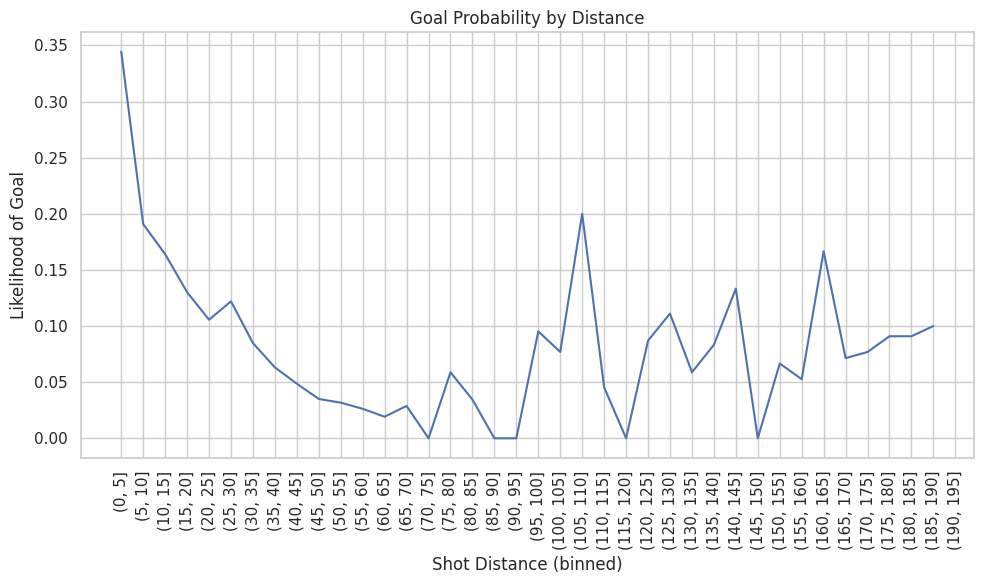

In [ ]:
#calculate the probability of goal based on the shot distance

df['distance_bin'] = pd.cut(df['shot_distance'], bins=range(0, 200, 5))

#take all the shots for the bin distance and find the probability of it being a goal. (all the 1s/by all shots)
goal_rates = (
    df.groupby('distance_bin')['is_goal']
       .mean()
       .reset_index()
)

#plot
plt.figure(figsize=(10, 6))

plt.plot(goal_rates['distance_bin'].astype(str),
         goal_rates['is_goal'])

plt.xticks(rotation=90)
plt.xlabel("Shot Distance (binned)")
plt.ylabel("Likelihood of Goal")
plt.title("Goal Probability by Distance")
plt.tight_layout()
plt.show()

In [ ]:
#clean again for machine learning

del df["home_name"]
del df["event_team"]
del df["home_score"]
del df["away_score"]
del df["game_seconds_remaining"]
del df["description"]
df.head()

,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,is_goal,shot_side,angle_bin,distance_bin
0,SHOT,1,NaN,EV,61.0,-32.0,42.5,48.8,wrist,0,0,left,"(45, 50]","(40, 45]"
2,SHOT,1,NaN,EV,-65.0,19.0,30.6,38.4,wrist,0,0,right,"(35, 40]","(30, 35]"
3,SHOT,1,NaN,EV,-8.0,-27.0,100.7,15.6,wrist,0,0,left,"(15, 20]","(100, 105]"
4,SHOT,1,NaN,EV,-60.0,-4.0,29.3,7.9,wrist,0,0,left,"(5, 10]","(25, 30]"
5,SHOT,1,NaN,EV,63.0,4.0,26.3,8.7,wrist,0,0,right,"(5, 10]","(25, 30]"


In [ ]:
#hot encode non-numericle values

df["empty_net"] = df["empty_net"].astype(bool).astype(int)
strength_dummies = pd.get_dummies(df["strength_code"], prefix="strength").astype(int)
shot_type_dummies = pd.get_dummies(df["shot_type"], prefix="shot").astype(int)

df = pd.concat([df, strength_dummies, shot_type_dummies], axis=1)

df.head()

#make a copy to use for another ML
df1 = df.copy()



In [ ]:
#dop NaN values

df = df.dropna(subset=["period", "empty_net", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"])
df1 = df1.dropna(subset=["period", "empty_net", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"])

In [ ]:
#create predictors

p1 = ["period", "empty_net", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"]

#empty net is almost ALWAYS a goal so remove cause its an easy tell
p2= ["period", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"]


predictors = [p1, p2]


1
Accuracy: 99.55%


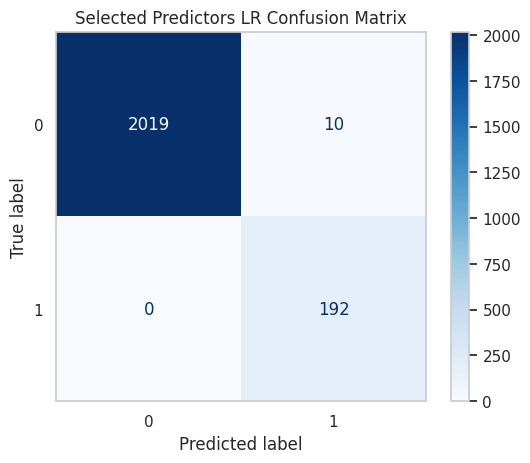

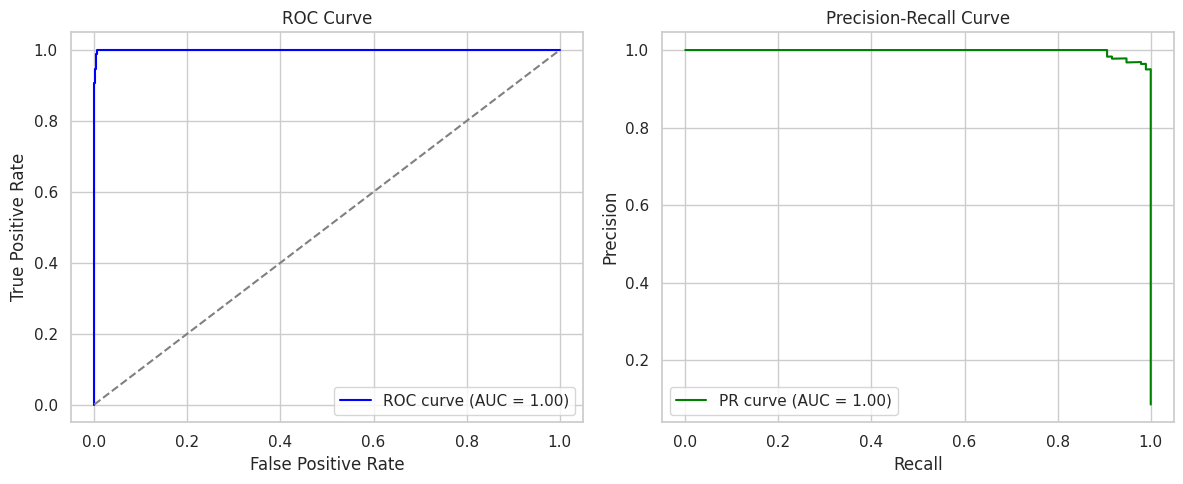

2
Accuracy: 72.94%


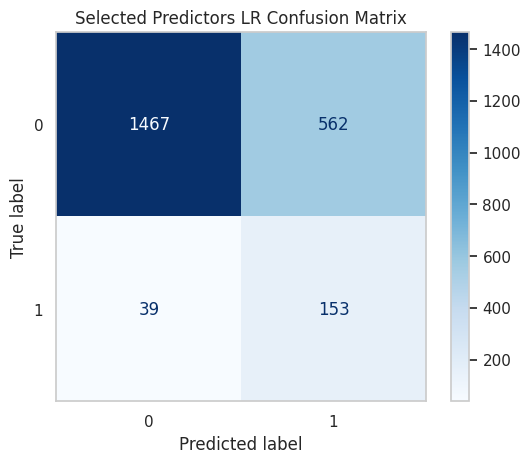

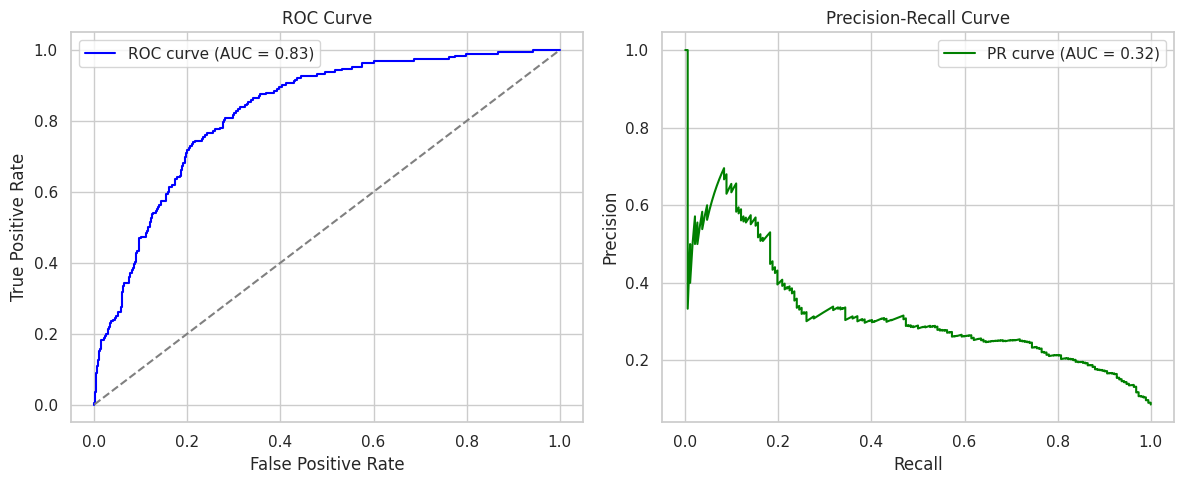

In [ ]:
#perform logistical regression to decide if its a goal based on the predictors

i = 1 #make visual part easier to read

#loop through the different lists of predictors
for p in predictors:

  X = df[p].values
  y = df["is_goal"].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # Split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=0
  )

  # Fit the model
  model = LogisticRegression(class_weight='balanced')
  model.fit(X_train, y_train)

  # Predict
  y_pred = model.predict(X_test)

  print(i)
  i+=1

  #print accuracy and confusion matrix
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: {:.2f}%".format(accuracy * 100))

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot(cmap="Blues")
  plt.grid(False)
  plt.title("Selected Predictors LR Confusion Matrix")
  plt.show()


  #compute probabilities for ROC and AUC for more understanding
  y_prob = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(12,5))

  # Plot ROC Curve
  plt.subplot(1,2,1)
  plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()

  # Plot Precision-Recall Curve
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  pr_auc = average_precision_score(y_test, y_prob)

  plt.subplot(1,2,2)
  plt.plot(recall, precision, color='green', label=f'PR curve (AUC = {pr_auc:.2f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
#understand which features impact the classification the most

feature_names = p2
coeffs = model.coef_[0]
odds_ratios = np.exp(coeffs)
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs,
    "odds_ratio": odds_ratios
})
print(coef_df)


              feature  coefficient  odds_ratio
0              period     0.180357    1.197645
1             x_fixed    -0.069280    0.933065
2             y_fixed    -0.001574    0.998427
3       shot_distance    -0.761552    0.466941
4          shot_angle    -0.186034    0.830245
5   goal_differential     0.748884    2.114639
6          shot_wrist    -0.039539    0.961232
7       shot_backhand    -0.033584    0.966974
8           shot_slap     0.040706    1.041546
9           shot_snap     0.021199    1.021426
10        shot_tip-in     0.049928    1.051196
11   shot_wrap_around    -0.046699    0.954375
12        strength_EV    -0.686971    0.503098
13        strength_PP    -0.381251    0.683006
14        strength_SH    -0.004731    0.995281


In [ ]:
#label encode to do multinomial regression

le = LabelEncoder()
df1['shot_outcome_label'] = le.fit_transform(df1['shot_outcome'])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 70.46%


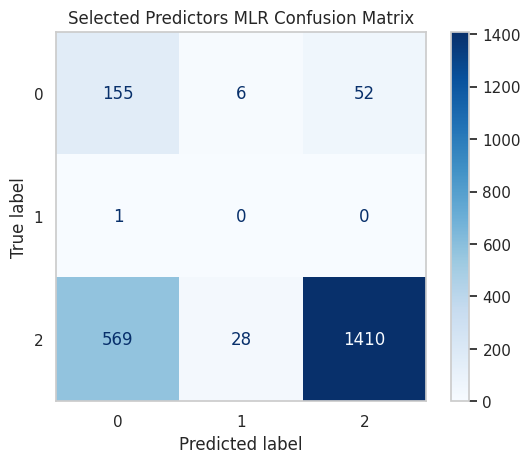

In [ ]:
#perform multinomial logistical regression for the different type of shot outcomes

p2= ["period", "x_fixed", "y_fixed", "shot_distance", "shot_angle",
              "goal_differential", "shot_wrist", "shot_backhand", "shot_slap", "shot_snap",
              "shot_tip-in","shot_wrap_around", "strength_EV", "strength_PP", "strength_SH"]


X = df1[p2].values
y = df1["shot_outcome_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)  # probabilities for each class

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.grid(False)
plt.title("Selected Predictors MLR Confusion Matrix")
plt.show()


In [ ]:
#understand which features impact the classification the most

coef_df = pd.DataFrame(model.coef_, columns=p2, index=model.classes_)
odds_ratio_df = np.exp(coef_df)
odds_ratio_df
coef_long = coef_df.reset_index().melt(id_vars='index', var_name='feature', value_name='coefficient')
coef_long['odds_ratio'] = np.exp(coef_long['coefficient'])
coef_long.rename(columns={'index':'class'}, inplace=True)
coef_long

,class,feature,coefficient,odds_ratio
0,0,period,0.464052,1.590506
1,1,period,-0.703902,0.494651
2,2,period,0.239850,1.271058
3,0,x_fixed,-0.007508,0.992520
4,1,x_fixed,0.013097,1.013183
5,2,x_fixed,-0.005588,0.994427
6,0,y_fixed,-0.005512,0.994503
7,1,y_fixed,0.010359,1.010413
8,2,y_fixed,-0.004847,0.995165
9,0,shot_distance,-0.055217,0.946280


Accuracy: 90.32%


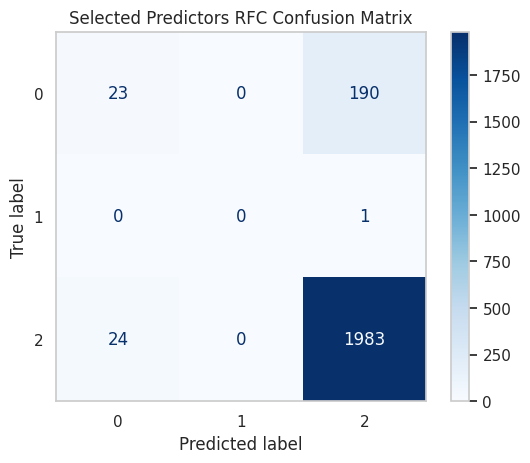

In [ ]:
#see if a random forest classifier prforms better for the multinomial classification

model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)  # probabilities for each class

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.grid(False)
plt.title("Selected Predictors RFC Confusion Matrix")
plt.show()

In [ ]:
# Collecting relevant features

X_xg = df[p2].values
X_xg_scaled = scaler.transform(X_xg)
df['xG'] = model.predict_proba(X_xg_scaled)[:, 1]
df.head()

,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,...,strength_PP,strength_SH,shot_backhand,shot_slap,shot_snap,shot_tip-in,shot_wrap_around,shot_wrist,xG,xG_category
0,SHOT,1,1,EV,61.0,-32.0,42.5,48.8,wrist,0,...,0,0,0,0,0,0,0,1,0.0,low probability
2,SHOT,1,1,EV,-65.0,19.0,30.6,38.4,wrist,0,...,0,0,0,0,0,0,0,1,0.0,low probability
3,SHOT,1,1,EV,-8.0,-27.0,100.7,15.6,wrist,0,...,0,0,0,0,0,0,0,1,0.0,low probability
4,SHOT,1,1,EV,-60.0,-4.0,29.3,7.9,wrist,0,...,0,0,0,0,0,0,0,1,0.0,low probability
5,SHOT,1,1,EV,63.0,4.0,26.3,8.7,wrist,0,...,0,0,0,0,0,0,0,1,0.0,low probability


In [ ]:
# Re-train binary Logistic Regression model and scaler specifically for xG calculation.

X_xg_calc = df[p2].values
y_xg_calc = df["is_goal"].values

binary_scaler = StandardScaler()
X_xg_calc_scaled = binary_scaler.fit_transform(X_xg_calc)

binary_log_reg_model = LogisticRegression(class_weight='balanced')
binary_log_reg_model.fit(X_xg_calc_scaled, y_xg_calc)

print("Dedicated binary Logistic Regression model and scaler trained for xG calculation.")

Dedicated binary Logistic Regression model and scaler trained for xG calculation.


In [ ]:
# Collecting relevant features and calculating xG

X_xg = df[p2].values
X_xg_scaled = binary_scaler.transform(X_xg)
df['xG'] = binary_log_reg_model.predict_proba(X_xg_scaled)[:, 1]
df.head()

,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,...,strength_PP,strength_SH,shot_backhand,shot_slap,shot_snap,shot_tip-in,shot_wrap_around,shot_wrist,xG,xG_category
0,SHOT,1,1,EV,61.0,-32.0,42.5,48.8,wrist,0,...,0,0,0,0,0,0,0,1,0.192764,low probability
2,SHOT,1,1,EV,-65.0,19.0,30.6,38.4,wrist,0,...,0,0,0,0,0,0,0,1,0.304443,low probability
3,SHOT,1,1,EV,-8.0,-27.0,100.7,15.6,wrist,0,...,0,0,0,0,0,0,0,1,0.050025,low probability
4,SHOT,1,1,EV,-60.0,-4.0,29.3,7.9,wrist,0,...,0,0,0,0,0,0,0,1,0.390817,low probability
5,SHOT,1,1,EV,63.0,4.0,26.3,8.7,wrist,0,...,0,0,0,0,0,0,0,1,0.367386,low probability


In [ ]:
# Setting a threshold for if a shot has high or low probability

xg_threshold = df['xG'].quantile(0.75)
if xg_threshold == 0:
    xg_threshold = 0.01

df['xG_category'] = df['xG'].apply(lambda x: 'high probability' if x >= xg_threshold else 'low probability')
print(f"New xG threshold for high probability shots: {xg_threshold:.4f}")
df.head()

New xG threshold for high probability shots: 0.5625


,shot_outcome,period,empty_net,strength_code,x_fixed,y_fixed,shot_distance,shot_angle,shot_type,goal_differential,...,strength_PP,strength_SH,shot_backhand,shot_slap,shot_snap,shot_tip-in,shot_wrap_around,shot_wrist,xG,xG_category
0,SHOT,1,1,EV,61.0,-32.0,42.5,48.8,wrist,0,...,0,0,0,0,0,0,0,1,0.192764,low probability
2,SHOT,1,1,EV,-65.0,19.0,30.6,38.4,wrist,0,...,0,0,0,0,0,0,0,1,0.304443,low probability
3,SHOT,1,1,EV,-8.0,-27.0,100.7,15.6,wrist,0,...,0,0,0,0,0,0,0,1,0.050025,low probability
4,SHOT,1,1,EV,-60.0,-4.0,29.3,7.9,wrist,0,...,0,0,0,0,0,0,0,1,0.390817,low probability
5,SHOT,1,1,EV,63.0,4.0,26.3,8.7,wrist,0,...,0,0,0,0,0,0,0,1,0.367386,low probability


In [ ]:
# Print the number of high probability shots

high_prob_shots = df[df['xG_category'] == 'high probability'].shape[0]
print(f"Number of high probability shots: {high_prob_shots}")

Number of high probability shots: 2777


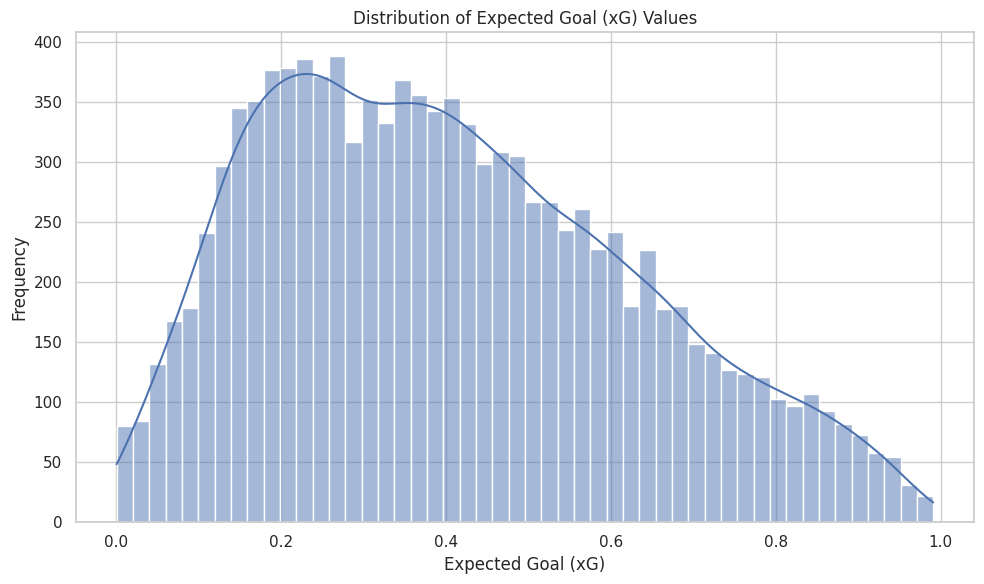

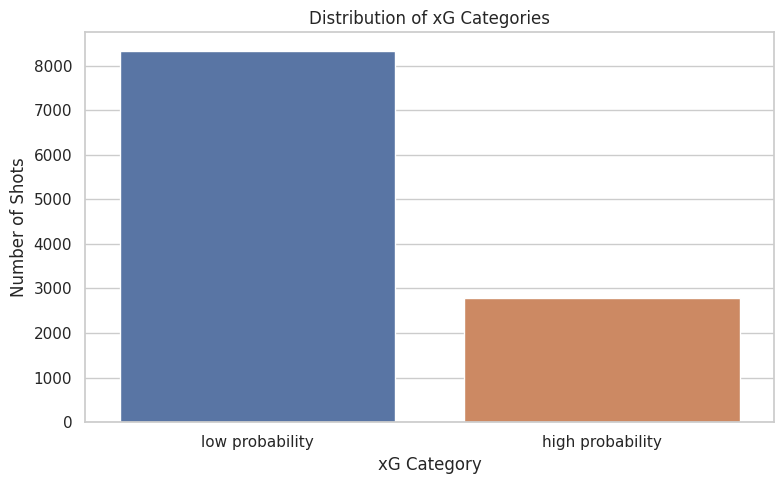

        xG_category   is_goal
0  high probability  0.241628
1   low probability  0.047550


In [ ]:
# Plots to help show the distribution of shots

plt.figure(figsize=(10, 6))
sns.histplot(df['xG'], bins=50, kde=True)
plt.title('Distribution of Expected Goal (xG) Values')
plt.xlabel('Expected Goal (xG)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='xG_category', data=df, hue='xG_category', legend=False)
plt.title('Distribution of xG Categories')
plt.xlabel('xG Category')
plt.ylabel('Number of Shots')
plt.tight_layout()
plt.show()

goal_conversion_rates = df.groupby('xG_category')['is_goal'].mean().reset_index()
print(goal_conversion_rates)

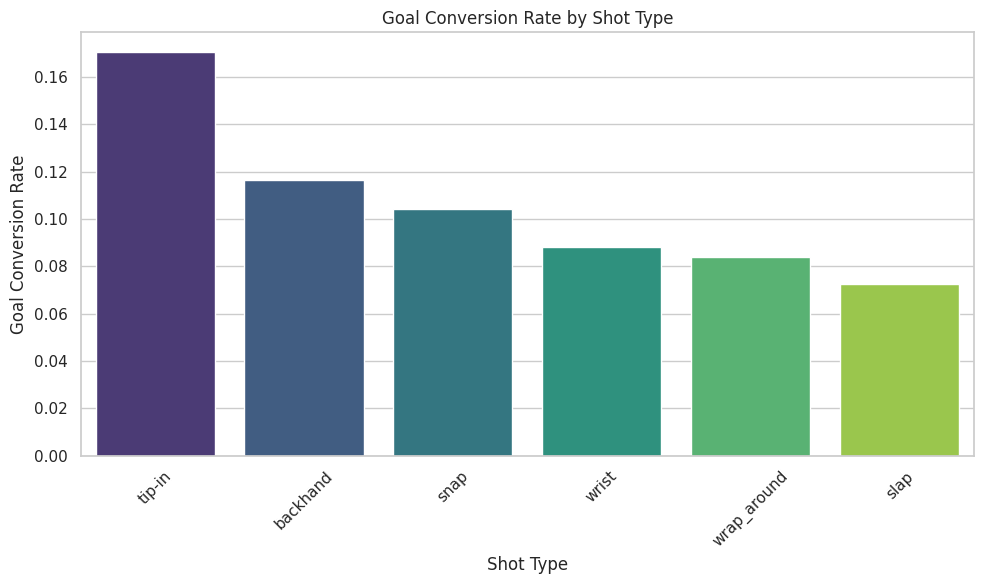

In [ ]:
shot_type_goal_rates = df.groupby('shot_type')['is_goal'].mean().reset_index()
shot_type_goal_rates = shot_type_goal_rates.sort_values(by='is_goal', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='shot_type', y='is_goal', data=shot_type_goal_rates, hue='shot_type', palette='viridis', legend=False)
plt.title('Goal Conversion Rate by Shot Type')
plt.xlabel('Shot Type')
plt.ylabel('Goal Conversion Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()